# Benchmarking Notebook for Generative Model


In [11]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
from pathlib import Path
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.kid import KernelInceptionDistance
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor
from diffusion_model.diffusion_model import DiffusionModel
from PIL import Image



In [12]:
# Initialize benchmark metrics
fid_metric = FrechetInceptionDistance(feature=2048).to('cuda')
is_metric = InceptionScore().to('cuda')
kid_metric = KernelInceptionDistance(subset_size=8).to('cuda')


100%|██████████| 1000/1000 [00:27<00:00, 36.67it/s]


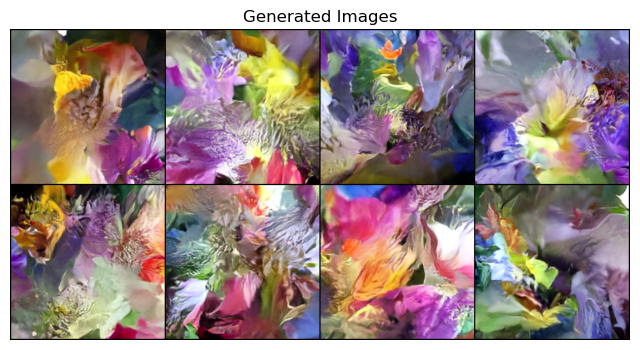

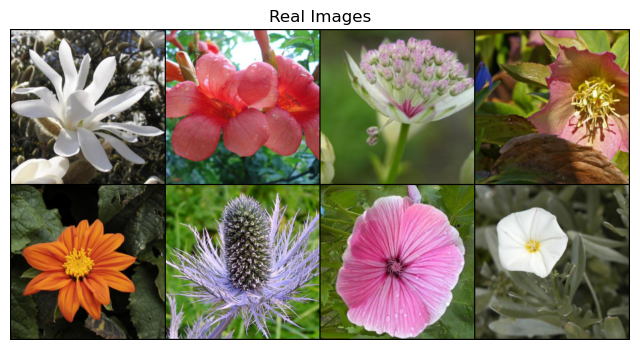

FID Score: 258.2329
Inception Score: Mean = 1.7107, Std = 0.3251
KID Score: 0.2119


In [15]:
def generate_and_benchmark(
        checkpoint: Path,
        num_timesteps: int = 1000,
        num_samples: int = 16,
        seed: int = 0,
        resolution: int = 256
):
    """Generates images from a trained DiffusionModel and benchmarks them with FID, IS, and KID."""

    # Set seed and device
    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model and load the checkpoint
    model = DiffusionModel.load_from_checkpoint(str(checkpoint))
    model.eval()
    model.to(device)

    # Prepare real images from the validation dataset
    transform = Compose([
        Resize(resolution),
        CenterCrop(resolution),
        ToTensor(),
    ])
    real_dataset = Flowers102(root="datasets", split="val", transform=transform, download=True)
    real_dataloader = DataLoader(real_dataset, batch_size=8, shuffle=True)

    with torch.inference_mode():
        all_generated_images = []
        all_real_images = []

        for real_batch in real_dataloader:
            real_images, _ = real_batch
            real_images = real_images.to(device)

            # Generate images
            generated_images = model.generate(
                num_images=len(real_images),
                diffusion_steps=num_timesteps,
                resolution=resolution
            )

            # Denormalize generated images
            generated_images = (generated_images * 0.5 + 0.5).clamp(0, 1)

            # Convert images for FID, IS, and KID
            generated_images_uint8 = (generated_images * 255).to(torch.uint8)
            real_images_uint8 = (real_images * 255).to(torch.uint8)

            # Update metrics
            fid_metric.update(generated_images_uint8, real=False)
            fid_metric.update(real_images_uint8, real=True)

            is_metric.update(generated_images_uint8)
            kid_metric.update(generated_images_uint8, real=False)
            kid_metric.update(real_images_uint8, real=True)

            all_generated_images.append(generated_images)
            all_real_images.append(real_images)

            # Stop after processing enough images
            if len(all_generated_images) * len(real_images) >= num_samples:
                break

        # Display the first batch of generated images
        grid_generated = tv.utils.make_grid(all_generated_images[0], nrow=4)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid_generated.permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.title("Generated Images")
        plt.show()

        # Display the first batch of real images
        grid_real = tv.utils.make_grid(all_real_images[0], nrow=4)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid_real.permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.title("Real Images")
        plt.show()

        # Save the first batch of generated images for inspection
        output_dir = Path("static/benchmark_generated_images")
        output_dir.mkdir(parents=True, exist_ok=True)
        for i, img_tensor in enumerate(all_generated_images[0]):
            img_array = (img_tensor.cpu().numpy().transpose(1, 2, 0) * 255).astype("uint8")
            img = Image.fromarray(img_array)
            img.save(output_dir / f"generated_image_{i}.png")

        # Save the first batch of real images for inspection
        real_output_dir = Path("static/benchmark_real_images")
        real_output_dir.mkdir(parents=True, exist_ok=True)
        for i, img_tensor in enumerate(all_real_images[0]):
            img_array = (img_tensor.cpu().numpy().transpose(1, 2, 0) * 255).astype("uint8")
            img = Image.fromarray(img_array)
            img.save(real_output_dir / f"real_image_{i}.png")

    # Compute and print metrics
    fid_score = fid_metric.compute().item()
    is_mean, is_std = is_metric.compute()
    kid_score = kid_metric.compute()[0].item()  # KID returns a tuple (mean, std)

    print(f"FID Score: {fid_score:.4f}")
    print(f"Inception Score: Mean = {is_mean:.4f}, Std = {is_std:.4f}")
    print(f"KID Score: {kid_score:.4f}")


# Example usage
generate_and_benchmark(
    checkpoint=Path("outputs/checkpoints/flower_diffusion_model-loss-epoch=171-train_loss=0.01.ckpt"),
    num_timesteps=1000,
    num_samples=16,
    seed=21,
    resolution=256
)
